In [1]:
# dataset load
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8CzHJJr0mbSZN5Yndqlp")
project = rf.workspace("project-986i8").project("drone-uskpc")
dataset = project.version(1).download("tensorflow")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 30.5 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninsta


Extracting Dataset Version Zip to Drone-1 in tensorflow:: 100%|██████████| 17714/17714 [00:05<00:00, 3299.53it/s]


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
# import pydicom
import warnings

from PIL import Image
import cv2

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

warnings.filterwarnings("ignore")


DIR_INPUT = '/kaggle/working/Drone-1'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VALID = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'

In [16]:
train_df = pd.read_csv(f'{DIR_TRAIN}/_annotations.csv')#[:100]
print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class"].nunique()))
train_df['class_id']=1
train_df.sort_values(by='filename').head(10)

df Shape: (16872, 8)
No Of Classes: 1


filename  width  height  class  \
4666   0002_jpg.rf.3a790caf1b59c891e289907a084398c5.jpg    640     640  drone   
12506  0002_jpg.rf.69e56a1e6be276fc287e9dcbdcfa6115.jpg    640     640  drone   
13552  0002_jpg.rf.798f1d27a95f0f002d90c9492e72a142.jpg    640     640  drone   
14343  0002_jpg.rf.84a8b847aa4ed282d3642992da46406b.jpg    640     640  drone   
14467  0002_jpg.rf.86c39bbe6a8a5a3e42f948e035b9c9d0.jpg    640     640  drone   
5585   0002_jpg.rf.90825f1af1d7397fba2fecf6039a4d0d.jpg    640     640  drone   
7906   0005_jpg.rf.473308791aa6a3aa2b73cee5a2e59317.jpg    640     640  drone   
9183   0005_jpg.rf.5b83ba0714843c5929a1c361b29bd50e.jpg    640     640  drone   
6792   0005_jpg.rf.a2e07d9502095c12244587ef9ed93ab9.jpg    640     640  drone   
15221  0005_jpg.rf.b5793489316a4a48acb5ac61458fb2a5.jpg    640     640  drone   

       xmin  ymin  xmax  ymax  class_id  
4666    344   236   426   290         1  
12506   350   269   425   292         1  
13552   351   204   435   267         1  
14343   350   269   425   292         1  
14467   319   253   399   295         1  
5585    380   242   462   278         1  
7906    182   100   286   177         1  
9183    287    84   374   116         1  
6792    367    88   464   155         1  
15221   306    67   399   106         1

In [17]:
valid_df = pd.read_csv(f'{DIR_VALID}/_annotations.csv')#[:10]
print("df Shape: "+str(valid_df.shape))
print("No Of Classes: "+str(valid_df["class"].nunique()))
valid_df['class_id']=1
valid_df.sort_values(by='filename').head(10)

df Shape: (1470, 8)
No Of Classes: 1


filename  width  height  class  \
256   0029_jpg.rf.2f03abd2787f80fb6d60bcbcbd785def.jpg    640     640  drone   
1098  0035_jpg.rf.bfd4f4c0eee5602f6fa5ae16b8846bde.jpg    640     640  drone   
419   0041_jpg.rf.4b20648c8273b207a5745fe2d5d9f52f.jpg    640     640  drone   
1368  0056_jpg.rf.e915f958a82d46b707667dc5bcb0f98e.jpg    640     640  drone   
11    0114_jpg.rf.025b24624438758236c3c31b79ea8418.jpg    640     640  drone   
1117  0158_jpg.rf.c398b84fe65e2da8b79f41042f12b1ba.jpg    640     640  drone   
6     0200_jpg.rf.01ae08a17440263514b38081f632e961.jpg    640     640  drone   
328   0227_jpg.rf.3c972ec8cd7a3ea836b4726787a9808e.jpg    640     640  drone   
487   0230_jpg.rf.5598cfd7bb60b7c0884c7b7cb68f47f0.jpg    640     640  drone   
1058  0247_jpg.rf.b865ea618cbfdda1fadbd5966826b3cd.jpg    640     640  drone   

      xmin  ymin  xmax  ymax  class_id  
256    288    87   372   111         1  
1098   290    93   369   108         1  
419    298    92   373   116         1  
1368   319    92   406   110         1  
11     365    96   458   116         1  
1117   311    97   375   120         1  
6      373    92   458   120         1  
328    372    94   460   121         1  
487    184   238   260   266         1  
1058   304    98   388   116         1

In [18]:
# Thanks -  https://www.kaggle.com/pestipeti/
class VinBigDataset(Dataset): #Class to load Training Data

    def __init__(self, dataframe, image_dir, transforms=None,stat = 'Train'):
        super().__init__()

        self.image_ids = dataframe["filename"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.stat = stat

    def __getitem__(self, index):
        if self.stat == 'Train':

            image_id = self.image_ids[index]
            records = self.df[(self.df['filename'] == image_id)]
            records = records.reset_index(drop=True)

            # dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            # image = dicom.pixel_array

            # if "PhotometricInterpretation" in dicom:
            #     if dicom.PhotometricInterpretation == "MONOCHROME1":
            #         image = np.amax(image) - image

            # intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            # slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            # if slope != 1:
            #     image = slope * image.astype(np.float64)
            #     image = image.astype(np.int16)


            # image += np.int16(intercept)

            # image = np.stack([image, image, image])
            # image = image.astype('float32')
            # image = image - image.min()
            # image = image / image.max()
            # image = image * 255.0
            # image = image.transpose(1,2,0)
            image = cv2.imread(f"{self.image_dir}/{image_id}")
            image = image / 255.0

            # if records.loc[0, "class_id"] == 0:
            #     records = records.loc[[0], :]

            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            # target['image_id'] = torch.tensor([index])
            # target['area'] = area
            # target['iscrowd'] = iscrowd

            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']

                target['boxes'] = torch.tensor(sample['bboxes'])

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
                # target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)

            return image, target, image_id

        else:

            image_id = self.image_ids[index]
            records = self.df[(self.df['filename'] == image_id)]
            records = records.reset_index(drop=True)

            # dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            # image = dicom.pixel_array

            # intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            # slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            # if slope != 1:
            #     image = slope * image.astype(np.float64)
            #     image = image.astype(np.int16)

            # image += np.int16(intercept)

            # image = np.stack([image, image, image])
            # image = image.astype('float32')
            # image = image - image.min()
            # image = image / image.max()
            # image = image * 255.0
            # image = image.transpose(1,2,0)
            image = cv2.imread(f"{self.image_dir}/{image_id}")
            image = image / 255.0

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 157MB/s]  


In [19]:
num_classes = 2 # 

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VinBigDataset(train_df, DIR_TRAIN, ToTensorV2(p=1.0))#, get_train_transform())
valid_dataset = VinBigDataset(valid_df, DIR_TRAIN, ToTensorV2(p=1.0))#, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
# Create train and validate data loader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

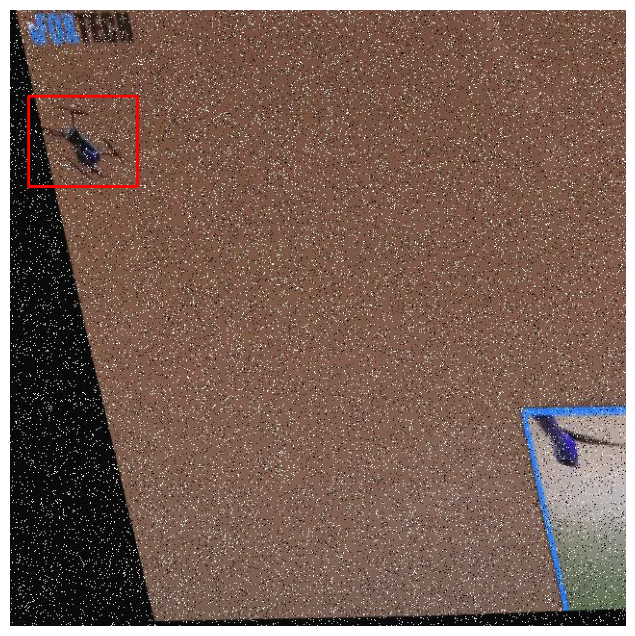

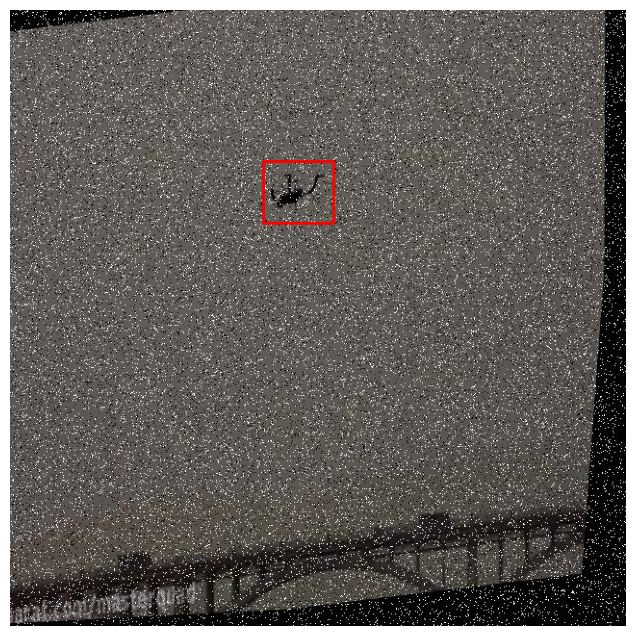

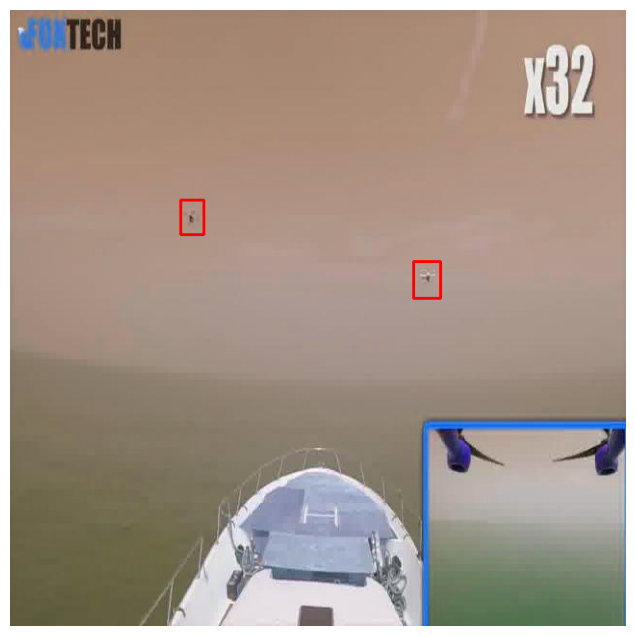

In [22]:
# Train dataset sample
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for number in random.sample([1,2,3],3):
  boxes = targets[number]['boxes'].cpu().numpy().astype(np.int32)
  img = images[number].permute(1,2,0).cpu().numpy()
  labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))

  for i in range(len(boxes)):
      img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
      #print(le.inverse_transform([labels[i]-1])[0])
      #print(label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])))
      # img = cv2.putText(img, labels[i], (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,1, (255,0,0), 2, cv2.LINE_AA)

  ax.set_axis_off()
  ax.imshow(img)

In [23]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [24]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs =  4 #Low epoch to save GPU time

In [25]:
loss_hist = Averager()
itr = 1
lossHistoryiter = []
lossHistoryepoch = []

import time
start = time.time()
import tqdm
for epoch in range(num_epochs):
    loss_hist.reset()

    for images, targets, image_ids in tqdm.tqdm(train_data_loader):

        images = list(image.float().to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)
        lossHistoryiter.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    lossHistoryepoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

  3%|▎         | 50/1961 [01:15<49:25,  1.55s/it] 

Iteration #50 loss: 0.20540551841259003


  5%|▌         | 100/1961 [02:36<48:59,  1.58s/it]

Iteration #100 loss: 0.18769212067127228


  8%|▊         | 150/1961 [03:56<48:25,  1.60s/it]

Iteration #150 loss: 0.19997812807559967


 10%|█         | 200/1961 [05:17<47:25,  1.62s/it]

Iteration #200 loss: 0.1376732885837555


 13%|█▎        | 250/1961 [06:38<46:06,  1.62s/it]

Iteration #250 loss: 0.11363434046506882


 15%|█▌        | 300/1961 [07:59<44:41,  1.61s/it]

Iteration #300 loss: 0.10728104412555695


 18%|█▊        | 350/1961 [09:19<43:31,  1.62s/it]

Iteration #350 loss: 0.12737631797790527


 20%|██        | 400/1961 [10:40<41:40,  1.60s/it]

Iteration #400 loss: 0.13815008103847504


 23%|██▎       | 450/1961 [12:00<40:28,  1.61s/it]

Iteration #450 loss: 0.13422054052352905


 25%|██▌       | 500/1961 [13:21<39:06,  1.61s/it]

Iteration #500 loss: 0.10537078976631165


 28%|██▊       | 550/1961 [14:41<37:38,  1.60s/it]

Iteration #550 loss: 0.13764603435993195


 31%|███       | 600/1961 [16:01<36:43,  1.62s/it]

Iteration #600 loss: 0.10959914326667786


 33%|███▎      | 650/1961 [17:22<35:26,  1.62s/it]

Iteration #650 loss: 0.15555408596992493


 36%|███▌      | 700/1961 [18:43<34:06,  1.62s/it]

Iteration #700 loss: 0.1296226680278778


 38%|███▊      | 750/1961 [20:04<32:44,  1.62s/it]

Iteration #750 loss: 0.1439320147037506


 41%|████      | 800/1961 [21:25<31:16,  1.62s/it]

Iteration #800 loss: 0.10976578295230865


 43%|████▎     | 850/1961 [22:45<29:51,  1.61s/it]

Iteration #850 loss: 0.11736644804477692


 46%|████▌     | 900/1961 [24:06<28:31,  1.61s/it]

Iteration #900 loss: 0.13768070936203003


 48%|████▊     | 950/1961 [25:27<27:17,  1.62s/it]

Iteration #950 loss: 0.0857742428779602


 51%|█████     | 1000/1961 [26:47<25:39,  1.60s/it]

Iteration #1000 loss: 0.16111738979816437


 54%|█████▎    | 1050/1961 [28:08<24:34,  1.62s/it]

Iteration #1050 loss: 0.14512012898921967


 56%|█████▌    | 1100/1961 [29:29<23:15,  1.62s/it]

Iteration #1100 loss: 0.1349174678325653


 59%|█████▊    | 1150/1961 [30:50<21:51,  1.62s/it]

Iteration #1150 loss: 0.1303439736366272


 61%|██████    | 1200/1961 [32:11<20:28,  1.61s/it]

Iteration #1200 loss: 0.1483355611562729


 64%|██████▎   | 1250/1961 [33:31<19:02,  1.61s/it]

Iteration #1250 loss: 0.1370519995689392


 66%|██████▋   | 1300/1961 [34:51<17:41,  1.61s/it]

Iteration #1300 loss: 0.11829684674739838


 69%|██████▉   | 1350/1961 [36:12<16:21,  1.61s/it]

Iteration #1350 loss: 0.09485965222120285


 71%|███████▏  | 1400/1961 [37:32<14:58,  1.60s/it]

Iteration #1400 loss: 0.10896851122379303


 74%|███████▍  | 1450/1961 [38:53<13:38,  1.60s/it]

Iteration #1450 loss: 0.09397276490926743


 76%|███████▋  | 1500/1961 [40:13<12:27,  1.62s/it]

Iteration #1500 loss: 0.120444156229496


 79%|███████▉  | 1550/1961 [41:33<11:02,  1.61s/it]

Iteration #1550 loss: 0.09185220301151276


 82%|████████▏ | 1600/1961 [42:54<09:42,  1.61s/it]

Iteration #1600 loss: 0.0751260295510292


 84%|████████▍ | 1650/1961 [44:14<08:20,  1.61s/it]

Iteration #1650 loss: 0.12645235657691956


 87%|████████▋ | 1700/1961 [45:35<07:00,  1.61s/it]

Iteration #1700 loss: 0.11532853543758392


 89%|████████▉ | 1750/1961 [46:56<05:38,  1.60s/it]

Iteration #1750 loss: 0.1248888224363327


 92%|█████████▏| 1800/1961 [48:16<04:19,  1.61s/it]

Iteration #1800 loss: 0.15017765760421753


 94%|█████████▍| 1850/1961 [49:37<02:59,  1.62s/it]

Iteration #1850 loss: 0.127410888671875


 97%|█████████▋| 1900/1961 [50:58<01:38,  1.62s/it]

Iteration #1900 loss: 0.12471499294042587


 99%|█████████▉| 1950/1961 [52:18<00:17,  1.61s/it]

Iteration #1950 loss: 0.11451904475688934


100%|██████████| 1961/1961 [52:36<00:00,  1.61s/it]


Epoch #0 loss: 0.1362750317363761


  2%|▏         | 39/1961 [01:02<51:41,  1.61s/it]

Iteration #2000 loss: 0.11399688571691513


  5%|▍         | 89/1961 [02:23<50:17,  1.61s/it]

Iteration #2050 loss: 0.15367035567760468


  7%|▋         | 139/1961 [03:43<49:01,  1.61s/it]

Iteration #2100 loss: 0.11233535408973694


 10%|▉         | 189/1961 [05:04<47:36,  1.61s/it]

Iteration #2150 loss: 0.10160047560930252


 12%|█▏        | 239/1961 [06:24<46:25,  1.62s/it]

Iteration #2200 loss: 0.0989147424697876


 15%|█▍        | 289/1961 [07:45<45:01,  1.62s/it]

Iteration #2250 loss: 0.1268891990184784


 17%|█▋        | 339/1961 [09:06<43:24,  1.61s/it]

Iteration #2300 loss: 0.12301109731197357


 20%|█▉        | 389/1961 [10:26<42:09,  1.61s/it]

Iteration #2350 loss: 0.08296670019626617


 22%|██▏       | 439/1961 [11:47<41:06,  1.62s/it]

Iteration #2400 loss: 0.10000038146972656


 25%|██▍       | 489/1961 [13:08<39:34,  1.61s/it]

Iteration #2450 loss: 0.1355469673871994


 27%|██▋       | 539/1961 [14:29<38:23,  1.62s/it]

Iteration #2500 loss: 0.15195855498313904


 30%|███       | 589/1961 [15:50<37:06,  1.62s/it]

Iteration #2550 loss: 0.1260564625263214


 33%|███▎      | 639/1961 [17:11<35:42,  1.62s/it]

Iteration #2600 loss: 0.2073904424905777


 35%|███▌      | 689/1961 [18:32<34:17,  1.62s/it]

Iteration #2650 loss: 0.10108835995197296


 38%|███▊      | 739/1961 [19:53<32:53,  1.62s/it]

Iteration #2700 loss: 0.09473484754562378


 40%|████      | 789/1961 [21:14<31:28,  1.61s/it]

Iteration #2750 loss: 0.12929131090641022


 43%|████▎     | 839/1961 [22:35<30:14,  1.62s/it]

Iteration #2800 loss: 0.13313552737236023


 45%|████▌     | 889/1961 [23:55<28:47,  1.61s/it]

Iteration #2850 loss: 0.0761842429637909


 48%|████▊     | 939/1961 [25:16<27:33,  1.62s/it]

Iteration #2900 loss: 0.12749820947647095


 50%|█████     | 989/1961 [26:37<26:06,  1.61s/it]

Iteration #2950 loss: 0.09440098702907562


 53%|█████▎    | 1039/1961 [27:58<24:52,  1.62s/it]

Iteration #3000 loss: 0.110260009765625


 56%|█████▌    | 1089/1961 [29:19<23:33,  1.62s/it]

Iteration #3050 loss: 0.08355305343866348


 58%|█████▊    | 1139/1961 [30:40<22:13,  1.62s/it]

Iteration #3100 loss: 0.09406857937574387


 61%|██████    | 1189/1961 [32:00<20:50,  1.62s/it]

Iteration #3150 loss: 0.12301743775606155


 63%|██████▎   | 1239/1961 [33:21<19:22,  1.61s/it]

Iteration #3200 loss: 0.07488613575696945


 66%|██████▌   | 1289/1961 [34:42<18:01,  1.61s/it]

Iteration #3250 loss: 0.08769754320383072


 68%|██████▊   | 1339/1961 [36:03<16:43,  1.61s/it]

Iteration #3300 loss: 0.10753848403692245


 71%|███████   | 1389/1961 [37:23<15:23,  1.61s/it]

Iteration #3350 loss: 0.11894615739583969


 73%|███████▎  | 1439/1961 [38:44<14:05,  1.62s/it]

Iteration #3400 loss: 0.1471061110496521


 76%|███████▌  | 1489/1961 [40:05<12:39,  1.61s/it]

Iteration #3450 loss: 0.10875323414802551


 78%|███████▊  | 1539/1961 [41:26<11:23,  1.62s/it]

Iteration #3500 loss: 0.07840010523796082


 81%|████████  | 1589/1961 [42:46<10:03,  1.62s/it]

Iteration #3550 loss: 0.09441372007131577


 84%|████████▎ | 1639/1961 [44:07<08:39,  1.61s/it]

Iteration #3600 loss: 0.12723319232463837


 86%|████████▌ | 1689/1961 [45:28<07:20,  1.62s/it]

Iteration #3650 loss: 0.07144255191087723


 89%|████████▊ | 1739/1961 [46:49<05:58,  1.62s/it]

Iteration #3700 loss: 0.1059192642569542


 91%|█████████ | 1789/1961 [48:10<04:37,  1.62s/it]

Iteration #3750 loss: 0.10208309441804886


 94%|█████████▍| 1839/1961 [49:30<03:16,  1.61s/it]

Iteration #3800 loss: 0.08295728266239166


 96%|█████████▋| 1889/1961 [50:51<01:56,  1.62s/it]

Iteration #3850 loss: 0.10453576594591141


 99%|█████████▉| 1939/1961 [52:12<00:35,  1.62s/it]

Iteration #3900 loss: 0.13119803369045258


100%|██████████| 1961/1961 [52:47<00:00,  1.62s/it]


Epoch #1 loss: 0.11192757319630499


  1%|▏         | 28/1961 [00:44<52:11,  1.62s/it]

Iteration #3950 loss: 0.07075293362140656


  4%|▍         | 78/1961 [02:05<50:42,  1.62s/it]

Iteration #4000 loss: 0.07273552566766739


  7%|▋         | 128/1961 [03:26<49:31,  1.62s/it]

Iteration #4050 loss: 0.12667155265808105


  9%|▉         | 178/1961 [04:47<47:58,  1.61s/it]

Iteration #4100 loss: 0.07584208250045776


 12%|█▏        | 228/1961 [06:08<46:45,  1.62s/it]

Iteration #4150 loss: 0.1182250827550888


 14%|█▍        | 278/1961 [07:29<45:31,  1.62s/it]

Iteration #4200 loss: 0.08563792705535889


 17%|█▋        | 328/1961 [08:50<44:00,  1.62s/it]

Iteration #4250 loss: 0.14518903195858002


 19%|█▉        | 378/1961 [10:11<42:45,  1.62s/it]

Iteration #4300 loss: 0.07816654443740845


 22%|██▏       | 428/1961 [11:32<41:11,  1.61s/it]

Iteration #4350 loss: 0.11285336315631866


 24%|██▍       | 478/1961 [12:53<40:00,  1.62s/it]

Iteration #4400 loss: 0.07606806606054306


 27%|██▋       | 528/1961 [14:14<38:38,  1.62s/it]

Iteration #4450 loss: 0.11252985149621964


 29%|██▉       | 578/1961 [15:35<37:24,  1.62s/it]

Iteration #4500 loss: 0.13400018215179443


 32%|███▏      | 628/1961 [16:56<35:54,  1.62s/it]

Iteration #4550 loss: 0.09555427730083466


 35%|███▍      | 678/1961 [18:16<34:27,  1.61s/it]

Iteration #4600 loss: 0.10643289238214493


 37%|███▋      | 728/1961 [19:37<33:18,  1.62s/it]

Iteration #4650 loss: 0.13432416319847107


 40%|███▉      | 778/1961 [20:58<31:59,  1.62s/it]

Iteration #4700 loss: 0.12206804007291794


 42%|████▏     | 828/1961 [22:19<30:37,  1.62s/it]

Iteration #4750 loss: 0.09847598522901535


 45%|████▍     | 878/1961 [23:40<29:17,  1.62s/it]

Iteration #4800 loss: 0.09455783665180206


 47%|████▋     | 928/1961 [25:01<27:57,  1.62s/it]

Iteration #4850 loss: 0.12829561531543732


 50%|████▉     | 978/1961 [26:22<26:32,  1.62s/it]

Iteration #4900 loss: 0.13439983129501343


 52%|█████▏    | 1028/1961 [27:43<25:12,  1.62s/it]

Iteration #4950 loss: 0.09938600659370422


 55%|█████▍    | 1078/1961 [29:04<23:51,  1.62s/it]

Iteration #5000 loss: 0.11867719143629074


 58%|█████▊    | 1128/1961 [30:25<22:29,  1.62s/it]

Iteration #5050 loss: 0.0727582648396492


 60%|██████    | 1178/1961 [31:45<20:57,  1.61s/it]

Iteration #5100 loss: 0.11764984577894211


 63%|██████▎   | 1228/1961 [33:06<19:44,  1.62s/it]

Iteration #5150 loss: 0.11350767314434052


 65%|██████▌   | 1278/1961 [34:27<18:23,  1.62s/it]

Iteration #5200 loss: 0.08041578531265259


 68%|██████▊   | 1328/1961 [35:48<17:05,  1.62s/it]

Iteration #5250 loss: 0.12931887805461884


 70%|███████   | 1378/1961 [37:09<15:41,  1.62s/it]

Iteration #5300 loss: 0.1594284176826477


 73%|███████▎  | 1428/1961 [38:30<14:20,  1.61s/it]

Iteration #5350 loss: 0.0821429193019867


 75%|███████▌  | 1478/1961 [39:51<13:00,  1.62s/it]

Iteration #5400 loss: 0.05476006492972374


 78%|███████▊  | 1528/1961 [41:11<11:39,  1.62s/it]

Iteration #5450 loss: 0.10458583384752274


 80%|████████  | 1578/1961 [42:32<10:18,  1.62s/it]

Iteration #5500 loss: 0.12826716899871826


 83%|████████▎ | 1628/1961 [43:53<08:59,  1.62s/it]

Iteration #5550 loss: 0.08249279111623764


 86%|████████▌ | 1678/1961 [45:14<07:37,  1.62s/it]

Iteration #5600 loss: 0.09425656497478485


 88%|████████▊ | 1728/1961 [46:35<06:18,  1.62s/it]

Iteration #5650 loss: 0.0816434770822525


 91%|█████████ | 1778/1961 [47:56<04:55,  1.61s/it]

Iteration #5700 loss: 0.16470669209957123


 93%|█████████▎| 1828/1961 [49:16<03:34,  1.61s/it]

Iteration #5750 loss: 0.08675897121429443


 96%|█████████▌| 1878/1961 [50:37<02:14,  1.61s/it]

Iteration #5800 loss: 0.09699583053588867


 98%|█████████▊| 1928/1961 [51:58<00:53,  1.62s/it]

Iteration #5850 loss: 0.0884266346693039


100%|██████████| 1961/1961 [52:52<00:00,  1.62s/it]


Epoch #2 loss: 0.1039698380465899


  1%|          | 17/1961 [00:27<52:32,  1.62s/it]

Iteration #5900 loss: 0.08410350233316422


  3%|▎         | 67/1961 [01:48<51:07,  1.62s/it]

Iteration #5950 loss: 0.09734583646059036


  6%|▌         | 117/1961 [03:09<50:01,  1.63s/it]

Iteration #6000 loss: 0.08583154529333115


  9%|▊         | 167/1961 [04:30<48:30,  1.62s/it]

Iteration #6050 loss: 0.09677688032388687


 11%|█         | 217/1961 [05:51<47:05,  1.62s/it]

Iteration #6100 loss: 0.08506627380847931


 14%|█▎        | 267/1961 [07:12<45:57,  1.63s/it]

Iteration #6150 loss: 0.10880527645349503


 16%|█▌        | 317/1961 [08:33<44:25,  1.62s/it]

Iteration #6200 loss: 0.10645865648984909


 19%|█▊        | 367/1961 [09:54<42:56,  1.62s/it]

Iteration #6250 loss: 0.07246671617031097


 21%|██▏       | 417/1961 [11:15<41:41,  1.62s/it]

Iteration #6300 loss: 0.05667966976761818


 24%|██▍       | 467/1961 [12:36<40:12,  1.62s/it]

Iteration #6350 loss: 0.07163574546575546


 26%|██▋       | 517/1961 [13:57<38:56,  1.62s/it]

Iteration #6400 loss: 0.08747658878564835


 29%|██▉       | 567/1961 [15:18<37:31,  1.62s/it]

Iteration #6450 loss: 0.0606192983686924


 31%|███▏      | 617/1961 [16:38<36:07,  1.61s/it]

Iteration #6500 loss: 0.07102564722299576


 34%|███▍      | 667/1961 [17:59<34:58,  1.62s/it]

Iteration #6550 loss: 0.060153692960739136


 37%|███▋      | 717/1961 [19:20<33:40,  1.62s/it]

Iteration #6600 loss: 0.1226898804306984


 39%|███▉      | 767/1961 [20:41<32:12,  1.62s/it]

Iteration #6650 loss: 0.11302607506513596


 42%|████▏     | 817/1961 [22:02<30:59,  1.63s/it]

Iteration #6700 loss: 0.08178412914276123


 44%|████▍     | 867/1961 [23:23<29:25,  1.61s/it]

Iteration #6750 loss: 0.08996392041444778


 47%|████▋     | 917/1961 [24:44<28:13,  1.62s/it]

Iteration #6800 loss: 0.10390259325504303


 49%|████▉     | 967/1961 [26:05<26:52,  1.62s/it]

Iteration #6850 loss: 0.1450272798538208


 52%|█████▏    | 1017/1961 [27:26<25:26,  1.62s/it]

Iteration #6900 loss: 0.06296715885400772


 54%|█████▍    | 1067/1961 [28:47<24:09,  1.62s/it]

Iteration #6950 loss: 0.1536351442337036


 57%|█████▋    | 1117/1961 [30:08<22:51,  1.62s/it]

Iteration #7000 loss: 0.1500319391489029


 60%|█████▉    | 1167/1961 [31:29<21:26,  1.62s/it]

Iteration #7050 loss: 0.10036642104387283


 62%|██████▏   | 1217/1961 [32:50<20:06,  1.62s/it]

Iteration #7100 loss: 0.07110831141471863


 65%|██████▍   | 1267/1961 [34:11<18:45,  1.62s/it]

Iteration #7150 loss: 0.07085732370615005


 67%|██████▋   | 1317/1961 [35:32<17:21,  1.62s/it]

Iteration #7200 loss: 0.12600815296173096


 70%|██████▉   | 1367/1961 [36:53<16:00,  1.62s/it]

Iteration #7250 loss: 0.10948590189218521


 72%|███████▏  | 1417/1961 [38:14<14:40,  1.62s/it]

Iteration #7300 loss: 0.10753244161605835


 75%|███████▍  | 1467/1961 [39:35<13:19,  1.62s/it]

Iteration #7350 loss: 0.0752471536397934


 77%|███████▋  | 1517/1961 [40:56<12:00,  1.62s/it]

Iteration #7400 loss: 0.0765037089586258


 80%|███████▉  | 1567/1961 [42:17<10:38,  1.62s/it]

Iteration #7450 loss: 0.0821000412106514


 82%|████████▏ | 1617/1961 [43:38<09:21,  1.63s/it]

Iteration #7500 loss: 0.10571887344121933


 85%|████████▌ | 1667/1961 [44:59<07:56,  1.62s/it]

Iteration #7550 loss: 0.09328194707632065


 88%|████████▊ | 1717/1961 [46:21<06:34,  1.62s/it]

Iteration #7600 loss: 0.10179983079433441


 90%|█████████ | 1767/1961 [47:42<05:15,  1.63s/it]

Iteration #7650 loss: 0.10039447993040085


 93%|█████████▎| 1817/1961 [49:03<03:53,  1.62s/it]

Iteration #7700 loss: 0.10279269516468048


 95%|█████████▌| 1867/1961 [50:24<02:31,  1.61s/it]

Iteration #7750 loss: 0.11672181636095047


 98%|█████████▊| 1917/1961 [51:45<01:11,  1.62s/it]

Iteration #7800 loss: 0.07932384312152863


100%|██████████| 1961/1961 [52:56<00:00,  1.62s/it]

Epoch #3 loss: 0.0986744030903548
Time taken to Train the model :03:31:11.95


In [13]:
# torch.save(model.state_dict(), '/kaggle/working/model')
# from pytorch_lightning.callbacks import ModelCheckpoint
# model.save_checkpoint("mymodel.ckpt")
# new_model = MyModel.load_from_checkpoint(checkpoint_path="example.ckpt")


In [26]:
torch.save({'epoch': 4,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': lossHistoryepoch}, '/kaggle/working/mymodel.pth')

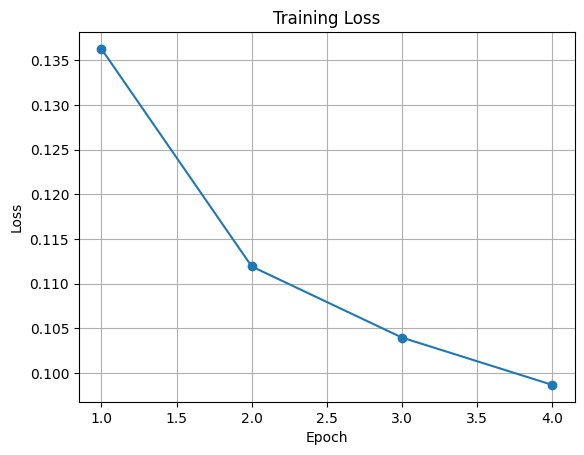

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot training loss
import matplotlib.pyplot as plt
# x = [i for i in range(num_epochs)]
y = lossHistoryepoch
# Plot scatter plot of training loss
x = np.arange(1, num_epochs+1)
colors = y  # Use loss values as colors

plt.plot(x, y, marker='o', linestyle='-')#, color=plt.cm.viridis(colors))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
# plt.colorbar(label='Loss')
plt.grid(True)
plt.show()
plt.savefig('plot.jpg')

In [15]:
# import plotly.graph_objects as go

# x = [i for i in range(num_epochs)]
# y = lossHistoryepoch
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=x,y=y,
#                     mode='lines',
#                     name='lines'))

# fig.update_layout(title='Loss vs Epochs',
#                    xaxis_title='Epochs',
#                    yaxis_title='Loss')
# fig.show()

In [34]:
DIR_TEST = f'{DIR_INPUT}/test'
test_df = pd.read_csv(f'{DIR_TEST}/_annotations.csv')#[:100]
print("df Shape: "+str(test_df.shape))
print("No Of Classes: "+str(test_df["class"].nunique()))
test_df['class_id']=1
test_df.sort_values(by='filename').head(10)

df Shape: (719, 8)
No Of Classes: 1


filename  width  height  class  \
115  0003_jpg.rf.221764dff4ad0a1b94c09b3c606d497c.jpg    640     640  drone   
441  0014_jpg.rf.9946695ac3a26f54fed495f1b49409d3.jpg    640     640  drone   
470  0154_jpg.rf.a431efc2fd080bb45197b6fecae13541.jpg    640     640  drone   
466  0222_jpg.rf.a3f45f5b903641a39afb14ae5c83d12a.jpg    640     640  drone   
62   0234_jpg.rf.1120ed29ddaeae58f6421bb81811fe44.jpg    640     640  drone   
538  0254_jpg.rf.b993fd71b1c1fc21641c9e5d89a81334.jpg    640     640  drone   
402  0256_jpg.rf.8d201cc28bbbe087b4e4fe15ab33c868.jpg    640     640  drone   
551  0266_jpg.rf.c0b7e0c4839227e0bf6bd3c9f9ea20b4.jpg    640     640  drone   
452  0269_jpg.rf.9d807920181b82276b7395780b7fbf3a.jpg    640     640  drone   
334  0333_jpg.rf.773d1038723b70466236bfa91e90e6c5.jpg    640     640  drone   

     xmin  ymin  xmax  ymax  class_id  
115   281    80   375   109         1  
441   364   264   430   285         1  
470   385    98   459   119         1  
466   372    94   453   118         1  
62    340    95   425   120         1  
538   217   116   286   140         1  
402   304    96   380   123         1  
551   195   151   265   185         1  
452   288   136   360   157         1  
334   308    91   408   118         1

In [35]:
labels =  targets[1]['labels'].cpu().numpy()
model.eval()
cpu_device = torch.device("cpu")

In [36]:
test_dataset = VinBigDataset(test_df, DIR_TEST, ToTensorV2(p=1.0))#,"Test")

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

In [37]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

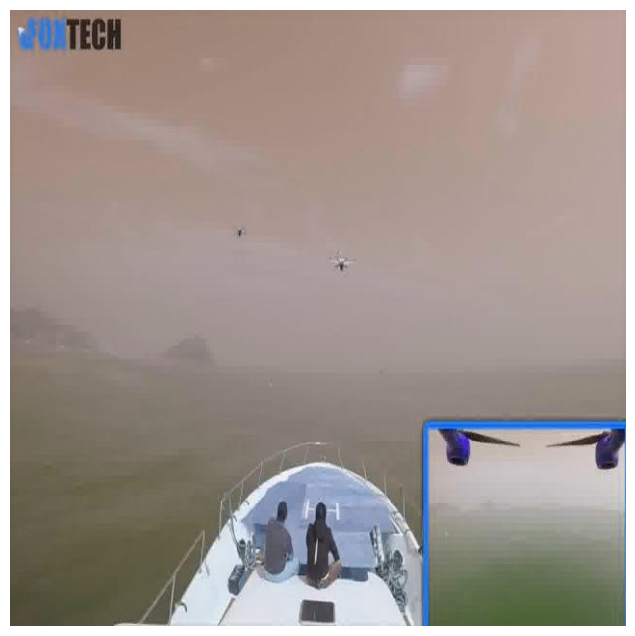

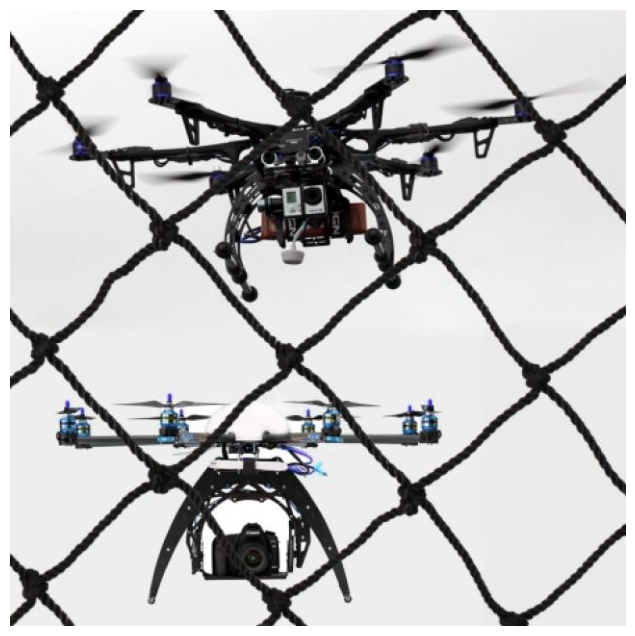

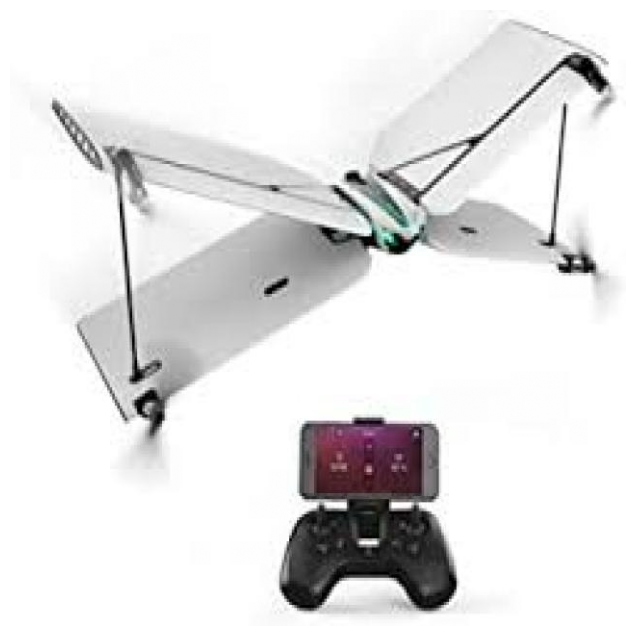

In [38]:
# Test dataset sample
images,target, image_ids = next(iter(test_data_loader))
images = list(image.to(device) for image in images)

for number in random.sample([1,2,3],3):
  img = images[number].permute(1,2,0).cpu().numpy()
  #labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  ax.set_axis_off()
  ax.imshow(img)

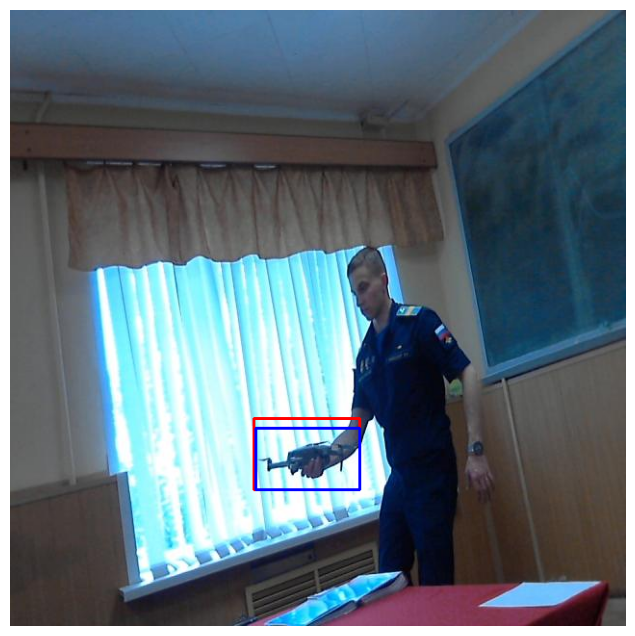

In [41]:
images,target, image_ids = next(iter(test_data_loader))
images = list(img.float().to(device) for img in images)

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]


boxes = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().detach().numpy()
labels= outputs[0]['labels'].cpu().detach().numpy().astype(np.int32)
score = outputs[0]['scores']

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
for i in range(len(boxes)):
  img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
  #print(le.inverse_transform([labels[i]-1])[0])
#   print(label_to_name(labels[i]), (boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize))
  # img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,3, (255,0,0), 3, cv2.LINE_AA)
t_boxes = target[0]['boxes'].cpu().detach().numpy().astype(np.int32)
for i in range(len(t_boxes)):
  img = cv2.rectangle(img,(t_boxes[i][0]+paddingSize,t_boxes[i][1]+paddingSize),(t_boxes[i][2]+paddingSize,t_boxes[i][3]+paddingSize),(0,0,255),2)
  
ax.set_axis_off()
ax.imshow(img)

In [44]:
# import pickle
# import logging
# import numpy as np
# import os
# import xml.etree.ElementTree as ET

# logger = logging.getLogger(__name__)


# def parse_rec(filename):
#     """ Parse a PASCAL VOC xml file """
#     tree = ET.parse(filename)
#     objects = []
#     for obj in tree.findall('object'):
#         obj_struct = {}
#         obj_struct['name'] = obj.find('name').text
#         obj_struct['pose'] = obj.find('pose').text
#         obj_struct['truncated'] = int(obj.find('truncated').text)
#         obj_struct['difficult'] = int(obj.find('difficult').text)
#         bbox = obj.find('bndbox')
#         obj_struct['bbox'] = [int(bbox.find('xmin').text) - 1,
#                               int(bbox.find('ymin').text) - 1,
#                               int(bbox.find('xmax').text) - 1,
#                               int(bbox.find('ymax').text) - 1]
#         objects.append(obj_struct)

#     return objects


# def voc_ap(rec, prec, use_07_metric=True):
#     """ ap = voc_ap(rec, prec, [use_07_metric])
#     Compute VOC AP given precision and recall.
#     If use_07_metric is true, uses the
#     VOC 07 11 point method (default:True).
#     """
#     if use_07_metric:
#         # 11 point metric
#         ap = 0.
#         for t in np.arange(0., 1.1, 0.1):
#             if np.sum(rec >= t) == 0:
#                 p = 0
#             else:
#                 p = np.max(prec[rec >= t])
#             ap = ap + p / 11.
#     else:
#         # correct AP calculation
#         # first append sentinel values at the end
#         mrec = np.concatenate(([0.], rec, [1.]))
#         mpre = np.concatenate(([0.], prec, [0.]))

#         # compute the precision envelope
#         for i in range(mpre.size - 1, 0, -1):
#             mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

#         # to calculate area under PR curve, look for points
#         # where X axis (recall) changes value
#         i = np.where(mrec[1:] != mrec[:-1])[0]

#         # and sum (\Delta recall) * prec
#         ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
#     return ap


# def voc_eval(detpath,
#              annopath,
#              imagesetfile,
#              classname,
#              cachedir,
#              ovthresh=0.5,
#              use_07_metric=True):
#     """rec, prec, ap = voc_eval(detpath,
#                            annopath,
#                            imagesetfile,
#                            classname,
#                            [ovthresh],
#                            [use_07_metric])
# Top level function that does the PASCAL VOC evaluation.
# detpath: Path to detections
#    detpath.format(classname) should produce the detection results file.
# annopath: Path to annotations
#    annopath.format(imagename) should be the xml annotations file.
# imagesetfile: Text file containing the list of images, one image per line.
# classname: Category name (duh)
# cachedir: Directory for caching the annotations
# [ovthresh]: Overlap threshold (default = 0.5)
# [use_07_metric]: Whether to use VOC07's 11 point AP computation
#    (default True)
# """
# # assumes detections are in detpath.format(classname)
# # assumes annotations are in annopath.format(imagename)
# # assumes imagesetfile is a text file with each line an image name
# # cachedir caches the annotations in a pickle file
# # first load gt
#     if not os.path.isdir(cachedir):
#         os.mkdir(cachedir)
#     cachefile = os.path.join(cachedir, 'annots.pkl')
#     # read list of images
#     with open(imagesetfile, 'r') as f:
#         lines = f.readlines()
#     imagenames = [x.strip() for x in lines]
#     if not os.path.isfile(cachefile):
#         # load annots
#         recs = {}
#         for i, imagename in enumerate(imagenames):
#             recs[imagename] = parse_rec(annopath % (imagename))
#             if i % 100 == 0:
#                 print('Reading annotation for {:d}/{:d}'.format(
#                    i + 1, len(imagenames)))
#         # save
#         print('Saving cached annotations to {:s}'.format(cachefile))
#         with open(cachefile, 'wb') as f:
#             pickle.dump(recs, f)
#     else:
#         # load
#         with open(cachefile, 'rb') as f:
#             recs = pickle.load(f)

#     # extract gt objects for this class
#     class_recs = {}
#     npos = 0
#     for imagename in imagenames:
#         R = [obj for obj in recs[imagename] if obj['name'] == classname]
#         bbox = np.array([x['bbox'] for x in R])
#         difficult = np.array([x['difficult'] for x in R]).astype(np.bool)
#         det = [False] * len(R)
#         npos = npos + sum(~difficult)
#         class_recs[imagename] = {'bbox': bbox,
#                                  'difficult': difficult,
#                                  'det': det}

#     # read dets
#     detfile = detpath.format(classname)
#     with open(detfile, 'r') as f:
#         lines = f.readlines()
#     if any(lines) == 1:

#         splitlines = [x.strip().split(' ') for x in lines]
#         image_ids = [x[0] for x in splitlines]
#         confidence = np.array([float(x[1]) for x in splitlines])
#         BB = np.array([[float(z) for z in x[2:]] for x in splitlines])

#         # sort by confidence
#         sorted_ind = np.argsort(-confidence)
#         sorted_scores = np.sort(-confidence)
#         BB = BB[sorted_ind, :]
#         image_ids = [image_ids[x] for x in sorted_ind]

#         # go down dets and mark TPs and FPs
#         nd = len(image_ids)
#         tp = np.zeros(nd)
#         fp = np.zeros(nd)
#         for d in range(nd):
#             R = class_recs[image_ids[d]]
#             bb = BB[d, :].astype(float)
#             ovmax = -np.inf
#             BBGT = R['bbox'].astype(float)
#             if BBGT.size > 0:
#                 # compute overlaps
#                 # intersection
#                 ixmin = np.maximum(BBGT[:, 0], bb[0])
#                 iymin = np.maximum(BBGT[:, 1], bb[1])
#                 ixmax = np.minimum(BBGT[:, 2], bb[2])
#                 iymax = np.minimum(BBGT[:, 3], bb[3])
#                 iw = np.maximum(ixmax - ixmin, 0.)
#                 ih = np.maximum(iymax - iymin, 0.)
#                 inters = iw * ih
#                 uni = ((bb[2] - bb[0]) * (bb[3] - bb[1]) +
#                        (BBGT[:, 2] - BBGT[:, 0]) *
#                        (BBGT[:, 3] - BBGT[:, 1]) - inters)
#                 overlaps = inters / uni
#                 ovmax = np.max(overlaps)
#                 jmax = np.argmax(overlaps)

#             if ovmax > ovthresh:
#                 if not R['difficult'][jmax]:
#                     if not R['det'][jmax]:
#                         tp[d] = 1.
#                         R['det'][jmax] = 1
#                     else:
#                         fp[d] = 1.
#             else:
#                 fp[d] = 1.

#         # compute precision recall
#         fp = np.cumsum(fp)
#         tp = np.cumsum(tp)
#         rec = tp / float(npos)
#         # avoid divide by zero in case the first detection matches a difficult
#         # ground truth
#         prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
#         ap = voc_ap(rec, prec, use_07_metric)
#     else:
#         rec = -1.
#         prec = -1.
#         ap = -1.

#     return rec, prec, ap

In [59]:
ovthresh=0.5
use_07_metric=True
tp = 0
fp = 0
npos = 0
def voc_ap(rec, prec, use_07_metric=True):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:True).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


start = time.time()
for images, targets, image_ids in tqdm.tqdm(test_data_loader):
    images = list(image.float().to(device) for image in images)
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    outputs = model(images)
    for tar,out in zip(targets,outputs):
#         print(tar['boxes'].size(),out['boxes'].size())
        bb = tar['boxes'].cpu().detach().numpy()
        BBGT = out['boxes'].cpu().detach().numpy()
        ixmin = np.maximum(BBGT[:, 0], bb[0,0])
        iymin = np.maximum(BBGT[:, 1], bb[0,1])
        ixmax = np.minimum(BBGT[:, 2], bb[0,2])
        iymax = np.minimum(BBGT[:, 3], bb[0,3])
        iw = np.maximum(ixmax - ixmin, 0.)
        ih = np.maximum(iymax - iymin, 0.)
        inters = iw * ih
        uni = ((bb[0,2] - bb[0,0]) * (bb[0,3] - bb[0,1]) +
                (BBGT[:, 2] - BBGT[:, 0]) *
                (BBGT[:, 3] - BBGT[:, 1]) - inters)
        overlaps = inters / uni
#         print(overlaps)
        if overlaps.size==0:
#             overlaps=[0]
            continue
#         else:
#             continue
        ovmax = np.max(overlaps)
        jmax = np.argmax(overlaps)
        if ovmax > ovthresh:
            tp+=1
        else:
            fp+=1
        npos+=bb.shape[0]
        

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Test the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

rec = tp / float(npos)
prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
ap = voc_ap(rec, prec, use_07_metric)


100%|██████████| 85/85 [01:04<00:00,  1.31it/s]

Time taken to Test the model :00:01:04.68


In [60]:
print('mean average precision:',ap)

mean average precision: 0.906381249153231
